In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Library untuk ekstraksi fitur dan machine learning
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from IPython.display import Image, display


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ======= Konfigurasi Parameter =======
LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'
DATASET_PATH = "/content/drive/Othercomputers/My Laptop/Semester 6/Pengolahan Citra/Teori/Tugas Besar/dataset-meat"

# ======= Fungsi Ekstraksi Fitur LBP =======
def extract_lbp_features(image_path):
    """Ekstraksi fitur LBP dari gambar grayscale."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, LBP_METHOD)

    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, LBP_POINTS + 3),
                           range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalisasi histogram
    return hist

# ======= Load Dataset dan Ekstraksi Fitur =======
def load_dataset_features(dataset_path):
    """Load seluruh gambar dari folder dataset dan ekstrak fitur LBP."""
    data, labels = [], []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            try:
                features = extract_lbp_features(file_path)
                data.append(features)
                labels.append(label)
            except Exception as e:
                print(f"❌ Error pada file {filename}: {e}")

    print("✅ Fitur LBP berhasil diekstrak dari seluruh gambar.")
    return pd.DataFrame(data), labels

# ======= Pelatihan Model Random Forest dengan Visualisasi Confusion Matrix =======
def train_lbp_classifier(X, y):
    """
    Melatih model Random Forest menggunakan fitur LBP dan
    menampilkan classification report serta visualisasi confusion matrix.
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Split data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Inisialisasi dan latih model Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prediksi data uji
    y_pred = model.predict(X_test)

    # Tampilkan classification report
    print("📝 Classification Report:\n", classification_report(y_test, y_pred))

    # Buat confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    labels = np.unique(y)

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return model

# ======= Prediksi dan Visualisasi =======
def show_prediction_with_lbp(image_path, model):
    """Menampilkan prediksi LBP beserta visualisasi gambar dan confidence."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Gambar tidak ditemukan: {image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, LBP_METHOD)

    # Ekstraksi histogram
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, LBP_POINTS + 3),
                           range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Prediksi
    proba = model.predict_proba([hist])[0]
    predicted_class = model.classes_[np.argmax(proba)]
    confidence = np.max(proba) * 100

    # Tampilkan prediksi
    print("🔎 Prediksi:")
    for cls, p in zip(model.classes_, proba):
        print(f" - {cls}: {p*100:.2f}%")
    print(f"\n✅ Prediksi Teratas: {predicted_class} ({confidence:.2f}%)")

    # Visualisasi gambar
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Gambar Asli")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lbp, cmap='gray')
    plt.title(f"LBP Image\nPrediksi: {predicted_class}\n({confidence:.2f}%)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

✅ Fitur LBP berhasil diekstrak dari seluruh gambar.
📝 Classification Report:
                    precision    recall  f1-score   support

Horse Meat (kuda)       0.81      0.81      0.81        31
      Meat (sapi)       1.00      1.00      1.00        16
      Pork (babi)       0.77      0.77      0.77        26

         accuracy                           0.84        73
        macro avg       0.86      0.86      0.86        73
     weighted avg       0.84      0.84      0.84        73



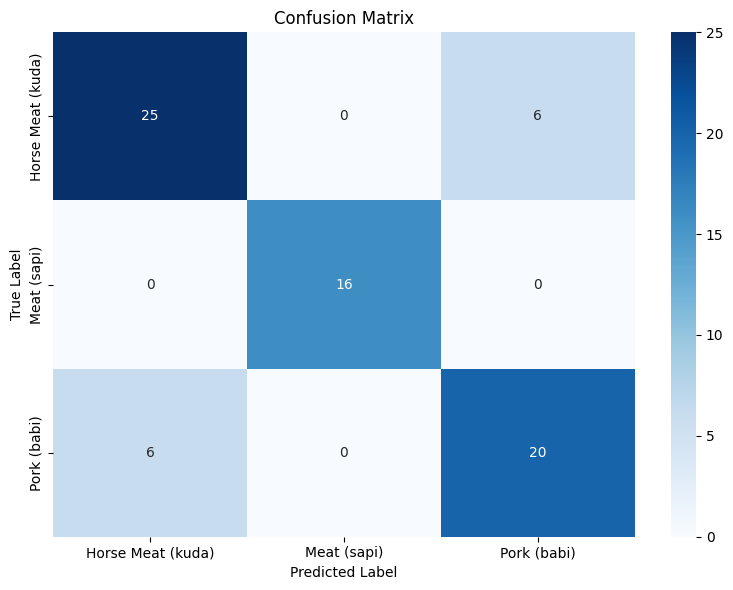

In [5]:
# ======= Main Pipeline =======
if __name__ == "__main__":
    # Load dan ekstrak fitur dari dataset
    df_features, labels = load_dataset_features(DATASET_PATH)
    df_features['label'] = labels

    # Split data
    X = df_features.drop(columns='label')
    y = df_features['label']

    # Train model
    lbp_model = train_lbp_classifier(X, y)

In [ ]:
    # Upload dan prediksi gambar baru
    uploaded = files.upload()
    for filename in uploaded.keys():
        display(Image(filename=filename))
        show_prediction_with_lbp(filename, lbp_model)